# Devoir de données massives : M2M0

$\underline{\text{auteur}}$ : Jean Zagdoun      


Ce notebook est le renud du premier DM de l'UE données massives du master M2MO à Paris-Diderot.      
Le but est d'étudier le corpus State of the union (SOTU) c'est un regroupement de messages présidentiels annuels adressés aux membres du congrès.      
L'idée est d'utiliser des méthode de NLP,notament celles vues en cours, pour exploiter ce jeu de données.

# Sommaire
<br> <font color=1a77ee , size=5>
- I) Tarvail sur le corpus Bush(sénior)-Clinton-Bush-Obama-Trump
    - I.1) extraction des features
    <br> <br>
    - I.2) analyse du jeu de donnée <br> <br> <br>
    
- II) etude du plagieurisme dans le corpus restreint <br> <br>  <br>

- III) Analyse approfondie du corpus entier
    - III.1) Etude descriptive du corpus
    <br> <br>
    - III.2) Analyse de sentiment <br> <br>
    -  III.3) LSH par Min Hashing

## I) Tarvail sur le corpus Bush(sénior)-Clinton-Bush-Obama-Trump 

Vu la taille du jeu de donnée originel nous travaillons en premier lieu sur les 5 derniers président des USA pour nous donner une idée des méthodes qui marches et pour détailler un peu plus l'analyse en profondeur (l'histoire des etats unis sur ces 200 dernières années n'étant pas ma première spécialité..)

     

### I.1) extraction des features

In [2]:
#bibliothèques qui sont utilisées dans ce notebook
import pandas as pd
import sklearn
import corenlp
import os
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import opinion_lexicon
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
import sys  
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown as md, Latex
from datasketch import MinHashLSH, MinHash
import seaborn as sns
import datetime
%matplotlib inline

In [3]:
data_folder = 'data_sotu_corpus'
fileNameList = [os.path.join(data_folder, fn) for fn in os.listdir(data_folder)]

In [4]:
porter = PorterStemmer()
df = pd.DataFrame(fileNameList, columns=['path'])
df['file'] = df.path.apply(lambda x: x.split('/')[-1])
df['president'] = df.file.apply(lambda x: x.split('_')[0])
df['full_text'] = df.path.apply(lambda x: open(x).read())
df['word_tokens2'] = df.path.apply(lambda x:  [porter.stem(word) for word in [word for word in word_tokenize(open(x).read().decode('utf8')) if word.isalpha()]])
#on a deja retiré toutes les anotations des mots dans word_tokens
#on garde quand même la structure des phrases pour essayer de faire des techniques de BOW ou d'extraire des lemmas d plus haut niveau
#idéalement et si le temps le permet nous essayeront d'implementer des méthode d'analyses séquentiel de texte 
#tel que des lstm ou autres réseaux récurents

      

<br>
Le code ci-dessus sert à extraire directement les lemmes du coprus et à les mettre dans le jeu de donnée nommé "df". Les lemmes sont dans la colonne word_tokens. Nous avons aussi garder l'intégralité du texte et le texte séparé en phrase pour des utilisations ultérieurs possibles
<br> <br>

In [5]:
df

,path,file,president,full_text,word_tokens2
0,data_sotu_corpus/Bush_2001.txt,Bush_2001.txt,Bush,"Mr. Speaker, Mr. Vice President, Members of Co...","[speaker, vice, presid, member, of, congress, ..."
1,data_sotu_corpus/Obama_2014.txt,Obama_2014.txt,Obama,"Mr. Speaker, Mr. Vice President, Members of Co...","[speaker, vice, presid, member, of, congress, ..."
2,data_sotu_corpus/Obama_2011.txt,Obama_2011.txt,Obama,Tonight I want to begin by congratulating the ...,"[tonight, I, want, to, begin, by, congratul, t..."
3,data_sotu_corpus/Obama_2012.txt,Obama_2012.txt,Obama,"Thank you, thank you. Everybody, please be sea...","[thank, you, thank, you, everybodi, pleas, be,..."
4,data_sotu_corpus/BushPere_1991.txt,BushPere_1991.txt,BushPere,"Mr. President, Mr. Speaker, members of the Uni...","[presid, speaker, member, of, the, unit, state..."
5,data_sotu_corpus/Clinton_1999.txt,Clinton_1999.txt,Clinton,"Mr. Speaker, Mr. Vice President, members of Co...","[speaker, vice, presid, member, of, congress, ..."
6,data_sotu_corpus/Bush_2003.txt,Bush_2003.txt,Bush,"Mr. Speaker, Vice President Cheney, members of...","[speaker, vice, presid, cheney, member, of, co..."
7,data_sotu_corpus/Obama_2016.txt,Obama_2016.txt,Obama,"Thank you. Mr. Speaker, Mr. Vice President, Me...","[thank, you, speaker, vice, presid, member, of..."
8,data_sotu_corpus/BushPere_1990.txt,BushPere_1990.txt,BushPere,"Tonight, I come not to speak about the ""State ...","[tonight, I, come, not, to, speak, about, the,..."
9,data_sotu_corpus/Obama_2010.txt,Obama_2010.txt,Obama,"Madam Speaker, Vice President Biden, members o...","[madam, speaker, vice, presid, biden, member, ..."


In [6]:
df["word_tokens2"][0][0:10]
# 11 premières lignes 

[u'speaker',
 u'vice',
 u'presid',
 u'member',
 u'of',
 u'congress',
 u'It',
 u'is',
 u'a',
 u'great']

In [7]:
df['word_tokens'] = df['word_tokens2'].copy()
for i in range(29):
    df['word_tokens'][i] = ' '.join(e for e in df['word_tokens2'][i])

In [8]:
df["word_tokens"][0][0:12]
#les treize premiers caractères

u'speaker vice'

Nous avons donc pus séparer les $\underline{lemmes}$ du textes original et nous avons créer un discours composé essentiellement de lemmes.     
Néanmoins nous avons aussi garder la structure en liste qui sera utile pour calculer la mesure de similarité : "jaccard"

### I.2) analyse du jeu de donnée   
   
   
Prochaine étape appliquées les méthodes de tfidf et de TDM (term document matrix).    

En premier lieu nous allons étudier des algorithmes "naïf" sur TF-IDF pour essayer d'avoir une interprétation possible du corpus réduits      

En l'occurance nous allons utiliser une méthode non supervisée de clustering pour essayer de faire apparître une "classification" que nous savons cohérente : la famille politique des président
        

In [9]:
#classes utile pour un affichage pertinant
# ref : https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

#dictionaire pour assigner une couleur par candidat
dcicolor = {
    'Trump' : '\033[95m',
    'Obama' : '\033[96m',
    'Clinton' : '\033[94m',
    'BushPere' : '\033[91m',
    'Bush'  :'\033[93m'}

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer , HashingVectorizer, CountVectorizer
from sklearn.cluster import KMeans

tdm = CountVectorizer(min_df= 4)
tfidf = TfidfVectorizer()
Hash = HashingVectorizer()

Words = pd.DataFrame(df['word_tokens'])
Text = pd.DataFrame(df['full_text'])

F = tdm.fit_transform(df['word_tokens'])
G = tfidf.fit_transform(df['full_text'])
H = tfidf.fit_transform(df['word_tokens'])

array = pd.DataFrame(H.toarray(),columns=tfidf.get_feature_names())
array

/home/zagdoun/anaconda2/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


,aaron,abandon,abba,abess,abid,abil,abl,abm,abolit,abort,...,your,yourself,yourselv,youth,zarfo,zarqawi,zero,zimbabw,zion,zone
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.008327,0.003112,0.0000,0.000000,0.000000,...,0.017213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002061,0.0000,0.000000,0.000000,...,0.008143,0.000000,0.000000,0.000000,0.000000,0.000000,0.004250,0.000000,0.000000,0.000000
2,0.000000,0.003017,0.000000,0.000000,0.000000,0.000000,0.007625,0.0000,0.000000,0.000000,...,0.010542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006159,0.0000,0.000000,0.000000,...,0.012976,0.000000,0.005357,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.004851,0.000000,0.000000,0.000000,0.000000,0.003065,0.0000,0.000000,0.000000,...,0.002422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009281
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.002307,0.003449,0.0000,0.000000,0.000000,...,0.010900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002611
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.003095,0.002314,0.0000,0.000000,0.005511,...,0.014624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002208,0.0000,0.000000,0.000000,...,0.006978,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.018966,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004543
9,0.000000,0.000000,0.000000,0.000000,0.004495,0.002524,0.001887,0.0000,0.000000,0.000000,...,0.002982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=20,verbose=0)
km.fit(H)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [12]:
print(color.BOLD + "groupe numéro 1 \n"+ color.END )
for i,j in enumerate(km.labels_):
    if (j ==0):
        print(color.BOLD +dcicolor[df['president'][i]] +  str(df['president'][i]) + color.END +" texte écris en "+  color.BOLD + str((df['file'][i].split('_')[1]).split('.')[0]) + color.END )

groupe numéro 1 

BushPere texte écris en 1991
Bush texte écris en 2003
BushPere texte écris en 1990
Bush texte écris en 2004
BushPere texte écris en 1989
Bush texte écris en 2005
Bush texte écris en 2002
Bush texte écris en 2008
Bush texte écris en 2007
Trump texte écris en 2017
Bush texte écris en 2006


In [13]:
print(color.BOLD + "groupe numéro 2\n"+ color.END )
for i,j in enumerate(km.labels_):
    if (j ==1):
        print(color.BOLD +dcicolor[df['president'][i]] +  str(df['president'][i]) + color.END +" texte écris en "+  color.BOLD + str((df['file'][i].split('_')[1]).split('.')[0]) + color.END )

groupe numéro 2

Bush texte écris en 2001
Obama texte écris en 2014
Obama texte écris en 2011
Obama texte écris en 2012
Clinton texte écris en 1999
Obama texte écris en 2016
Obama texte écris en 2010
BushPere texte écris en 1992
Clinton texte écris en 1997
Clinton texte écris en 1996
Clinton texte écris en 1995
Clinton texte écris en 1998
Obama texte écris en 2009
Obama texte écris en 2015
Clinton texte écris en 2000
Clinton texte écris en 1994
Clinton texte écris en 1993
Obama texte écris en 2013


avec un kmeans simple on arrive a séparer les 2 groupes politiques(Républicain et démocrate) des discours qu'ils tiennent.    

On remarque tout de même qu'un discours de bush junior c'est glissé parmis les démocrate (discours pré-9/11 donc quelque peu compréhensible)       
mais aussi le discours de Bush sénior daté de 1992      

Pour avoir une analyse plus détaillée nous allons augmenter le nombre de cluster 

In [14]:
km2 = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=40,verbose=0)
km2.fit(H)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=5, n_init=40, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
dic = {}
for k in range(5):
    print("\n" +color.BOLD  + "groupe numéro : " + str(k+1) + "\n" + color.END)
    for i, j in enumerate(km2.labels_):
        if j == k :
            print(dcicolor[df['president'][i]] + df['president'][i]+color.END+str((df['file'][i].split('_')[1]).split('.')[0]) )


groupe numéro : 1

Clinton1999
Clinton1997
Clinton1996
Clinton1995
Clinton1998
Clinton2000
Clinton1994
Clinton1993

groupe numéro : 2

BushPere1991
Bush2003
Bush2004
Bush2005
Bush2002
Bush2008
Bush2007
Trump2017
Bush2006

groupe numéro : 3

BushPere1990
BushPere1992
BushPere1989

groupe numéro : 4

Obama2014
Obama2011
Obama2012
Obama2016
Obama2010
Obama2009
Obama2015
Obama2013

groupe numéro : 5

Bush2001




## Conclusion de la première partie

nous avons donc réussi a plus ou moins séparer les différent president et ce juste en utilisant les tfidf des lemmes de chaques discours     
Une conclusion possible est que chaque président utilise un lexique qui lui est propre et il serait possible de l'identifier en utilisant des analyse c'est l'idée de base de la $\bf{ stylométrie}$  mais kmeans est un algorithme trop naïf pour une tache aussi sophistiquée la preuve sont les discours qui ont été mal classifiés :  
- G.W.Bush mais ce discours est pré 9/11 or si on regarde les discours de bush après le 11 septembre on trouve que le mote "terror" y est employer en moyenne une vingtaine de fois par discours.Dans le discours de 2001 il n'apparait qu'une seule fois.         
- D.Trump mais comme il n'a fait qu'un seul discours c'est logique, De plus il s'inscrit plus dans la politique de Bush junior que des autres candidats présent dans se corpus restreint.     
- George H. W. Bush, ce discours est celui de 1992 càd l'année où il perdra l'éléction présidentielle face à Bill Clinton.(le fait qu'il soit dans un cluster "démocratique" est à la fois ironique et peut-être même démontre d'une très bonne perplexité de sa part quand au aspirations politiques du peuple américain). Une explication plausible est que l'augmentation des impôts effectués aux USA à été une décision très impopulaire de sa part (et en plus une rupture de ses promesses de campagnes).    
Ainsi peut-être qu'en voyant le vent tourner il a plus accentuer son discours de 1992 sur la dimension sociale, ce qui ne ressemble pas trop à ses autres discours.

## II) etude du plagieurisme dans le corpus restreint

d'après le lien : https://www.politico.com/blogs/media/2014/01/bush-speechwriter-obama-plagiarized-bush-182184     
Le discours d'Obama de 2014 serais plagié sur celui de Bush de 2007      
Essayon d'anlyser cela mathématiquement grâce auxméthodes vues en cours

source du code: https://mattilyra.github.io/2017/05/23/document-deduplication-with-lsh.html

In [16]:
tdm21 = CountVectorizer()
tdm22 = CountVectorizer(max_df = 25)
J1 = tdm21.fit_transform(df['word_tokens'])
J2 = tdm22.fit_transform(df['word_tokens'])

#extraction des mots trop fréquents des corpus
ls1 = tdm21.get_feature_names()
ls2 = tdm22.get_feature_names()
ls = [val for val in ls1 if val not in ls2]

Obama_2014 = [word for word in df["word_tokens2"][1] if word not in ls and word not in stopwords.words('english')]
Bush_2007 = [word for word in df["word_tokens2"][26] if word not in ls and word not in stopwords.words('english')]

In [17]:
def jaccard(text_1,text_2):
    #calcul la similarité de jaccard comme vue en cours
    s1 = set(text_1)
    s2 = set(text_2)
    return float(len(s1 & s2)) / len(s1 | s2) 

In [18]:
print("\n"+df["president"][1]+" et "+df["president"][26]+" ont une similarité de Jaccard :"+color.BOLD+" %.4f"%(jaccard(Obama_2014,Bush_2007)))


Obama et Bush ont une similarité de Jaccard : 0.2378


Ainsi rien n'indique de manière mathématique un plagieurisme flagrant de la part de Barack Obama

Pour en avoir le coeur net il faurdrais lire les deux discours
<br>

In [19]:
Bush_2004 = [word for word in df["word_tokens2"][26] if word not in ls and word not in stopwords.words('english')]
Trump_2017 = [word for word in df["word_tokens2"][27] if word not in ls and word not in stopwords.words('english')]
print("\n"+df["president"][15]+" et "+df["president"][27]+" ont une similarité de Jaccard :"+color.BOLD+" %.4f"%(jaccard(Bush_2004,Trump_2017)))


Bush et Trump ont une similarité de Jaccard : 0.2267


Ainsi il y a une plus grande probabilité que D.Trump est plagiée G.W.Bush plustôt que se soit B.Obama qui ait plagié G.W.Bush. Ceci étant plustôt cohérent avec notre intuition     
Pour s'en donner une idée de manière informelle utilisons WordCloud 

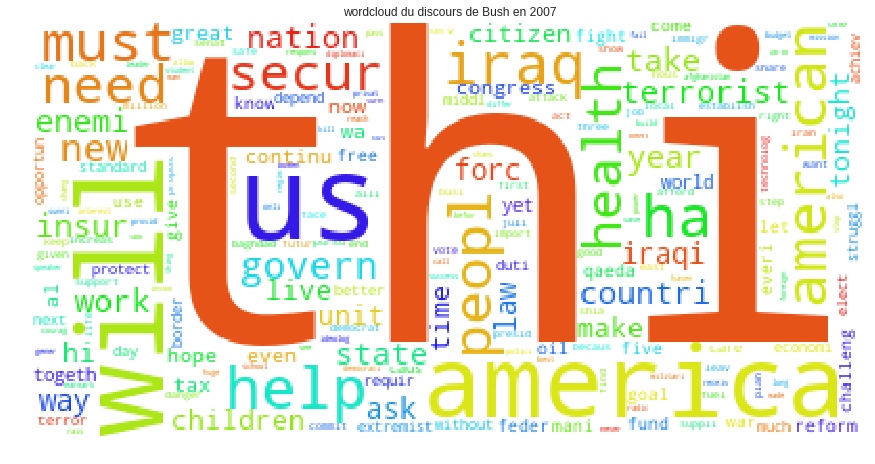

In [20]:
#source : https://blog.dominodatalab.com/lesser-known-ways-of-using-notebooks/
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white').generate(df["word_tokens"][26])
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("wordcloud du discours de Bush en 2007")
plt.show()

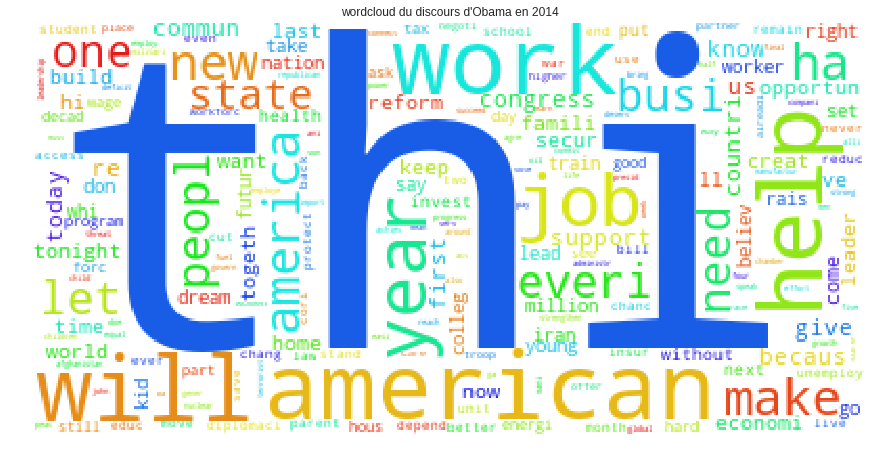

In [21]:
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white').generate(df["word_tokens"][1])
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("wordcloud du discours d'Obama en 2014")
plt.show()

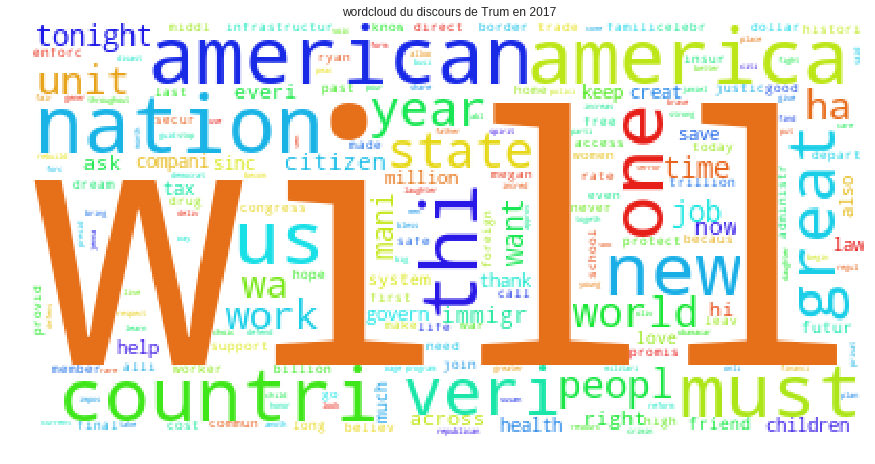

In [22]:
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white').generate(df["word_tokens"][27])
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("wordcloud du discours de Trum en 2017")
plt.show()

## III) Analyse approfondie du corpus entier 

on étudie maintenant un peu moins de 1000 textes différents, 962 pour être précis     

In [23]:
data_folder2 = 'extended_corpus'
fileNameList2 = [os.path.join(data_folder2, fn) for fn in os.listdir(data_folder2)]

In [24]:
df2 = pd.DataFrame(fileNameList2, columns=['path'])
df2['file'] = df2.path.apply(lambda x: x.split('/')[-1])
df2['president'] = df2.file.apply(lambda x: x.split('_')[0])
df2['word_tokens'] = df2.path.apply(lambda x:  [porter.stem(word) for word in [word for word in word_tokenize(open(x).read().decode('utf8')) if word.isalpha()]])
df2['full_text'] = df2.path.apply(lambda x: open(x).read())

In [25]:
for i in range(962):
    df2['word_tokens'][i] = ' '.join(e for e in df2['word_tokens'][i])

In [28]:
sent = nltk.sent_tokenize(df2['full_text'][0])

In [31]:
sent[0]

'<title="Second Annual Message">\n<date="December 5, 1898">\nTo the Senate and House of Representatives: \nNotwithstanding the added burdens rendered necessary by the war, our people rejoice in a very satisfactory and steadily increasing degree of prosperity, evidenced by the largest volume of business ever recorded.'

In [25]:
#extraction de l'année des textes
#tache plus dure qu'il n'y parait..
years = np.array([])
for i in range(962):
    data = df2['full_text'][i].split()
    s = df2['full_text'][i].split()[0]
    indice = 0
    while(s.isdigit() == False):
        indice = indice +1
        s = data[indice].split(",")[0]
    years = np.append(years, data[indice+1].split('"')[0].split('>')[0].split(')')[0])
    indice = 0
bad_indices = np.array([])
liste = ['1','2','3','4','5','6','7','8','9','0']
for i in range(962):
    if years[i][0] not in liste :
        bad_indices = np.append(bad_indices,i)
df2["years"] = years

### III.1) Etude descriptive du corpus

Nous allons tout d'abord répondre à des questions simple sur les corpus à commencer par:

- $\bf{\underline{\text{quels sont les lemmes les plus fréquents ?}}}$

In [26]:
#enlever les occurance qui ne sont pas significatives
#on utilise le parmaètre max_df de CountVectorizer() 
#méthode non optimal en terme de complexité...
tdm21 = CountVectorizer()
tdm22 = CountVectorizer(max_df = 800)
J1 = tdm21.fit_transform(df2['word_tokens'])
J2 = tdm22.fit_transform(df2['word_tokens'])

In [27]:
ls1 = tdm21.get_feature_names()
ls2 = tdm22.get_feature_names()
ls_aux = [val for val in ls1 if val not in stopwords.words('english')]

In [28]:
ls = [val for val in ls1 if val not in ls2 and val not in stopwords.words('english')]
#représente les mots les plus fréquents (on enlève les stopwords)

In [29]:
#affichage du resultat de manière "lisible"
display(md("<br> **Les lemmes les plus frequents** dans les 962 textes sont : <br><br> %s <br>  <br> \
ils apparaissent tous dans au moins **800** textes du coprus!<br><br>"%(ls)))

<br> **Les lemmes les plus frequents** dans les 962 textes sont : <br><br> [u'ani', u'countri', u'govern', u'ha', u'may', u'nation', u'one', u'peopl', u'state', u'thi', u'time', u'unit', u'wa', u'would'] <br>  <br> ils apparaissent tous dans au moins **800** textes du coprus!<br><br>

- $\bf{\underline{\text{combien y a-t-il de lemmes ?}}}$
 <br><br>

In [30]:
#affichge
print(color.BOLD+ "\n nous en avons extrait : %i \n"%len(ls_aux)+color.END)


 nous en avons extrait : 18390 



- $\bf{\underline{\text{comment ses lemmes sont-ils répartis?}}}$<br>
- $\underline{\text{quelle proportion de noms, verbes, adverbes et adjectifs dans le corpus?}}$
 <br><br>

In [31]:
#prend du temps pour tourner
count_noun = 0.
count_adv = 0.
count_verb = 0.
count_adj = 0.
Total = 0
for i in range(962):
    Tag = nltk.pos_tag(df2["word_tokens"][i],tagset='universal')
    for i in range(len(Tag)):
        Total += 1
        if Tag[i][1] == 'ADJ':
            count_adj += 1
        if Tag[i][1] == 'VERB':
            count_verb += 1
        if Tag[i][1] == 'NOUN':
            count_noun += 1
        if Tag[i][1] == 'ADV':
            count_adv += 1    

In [32]:
#affichage
display(md("<br> sur un total de **%i** mots extrait <br> \
*- %f sont des **noms** <br> - %f sont des **verbes** <br> - %f sont des **adverbes** <br> - %f sont des **adjectifs**<br> <br> *"%(Total,\
    float(count_noun)/Total,float(count_verb)/Total,float(count_adv)/Total,float(count_adj)/Total)))

<br> sur un total de **18983027** mots extrait <br> *- 0.677351 sont des **noms** <br> - 0.127910 sont des **verbes** <br> - 0.001638 sont des **adverbes** <br> - 0.107630 sont des **adjectifs**<br> <br> *

### III.2) Analyse de sentiment

La plus part du code ci-dessous s'inspire du notebook : https://www.kaggle.com/drumrick/sentiment-analysis-in-python       
L'idée est de faire de l'analyse de sentiment sur le corpus.

In [33]:
#pour faire de l'analyse d'opinion
positive = set(opinion_lexicon.positive())
negative = set(opinion_lexicon.negative())

In [34]:
DF = pd.DataFrame(fileNameList2, columns=['path'])
DF['file'] = DF.path.apply(lambda x: x.split('/')[-1])
DF['year'] = years
DF['president'] = DF.file.apply(lambda x: x.split('_')[0])
DF['tokens'] = DF.path.apply(lambda x: word_tokenize(open(x).read().decode("utf8")))
DF['positive'] = DF.tokens.apply(lambda x: len(positive.intersection(x)))
DF['negative'] = DF.tokens.apply(lambda x: len(negative.intersection(x)))
DF['sentiment'] = DF.positive - DF.negative
DF = DF[['file', 'positive', 'negative', 'sentiment', 'year', 'president']]

In [35]:
DF.drop(DF.index[bad_indices.astype(np.int32).tolist()], inplace=True)

In [36]:
DF= DF[~DF["president"].isin(["arthur"])]

In [37]:
DF["year"] = DF["year"].astype(np.int32)

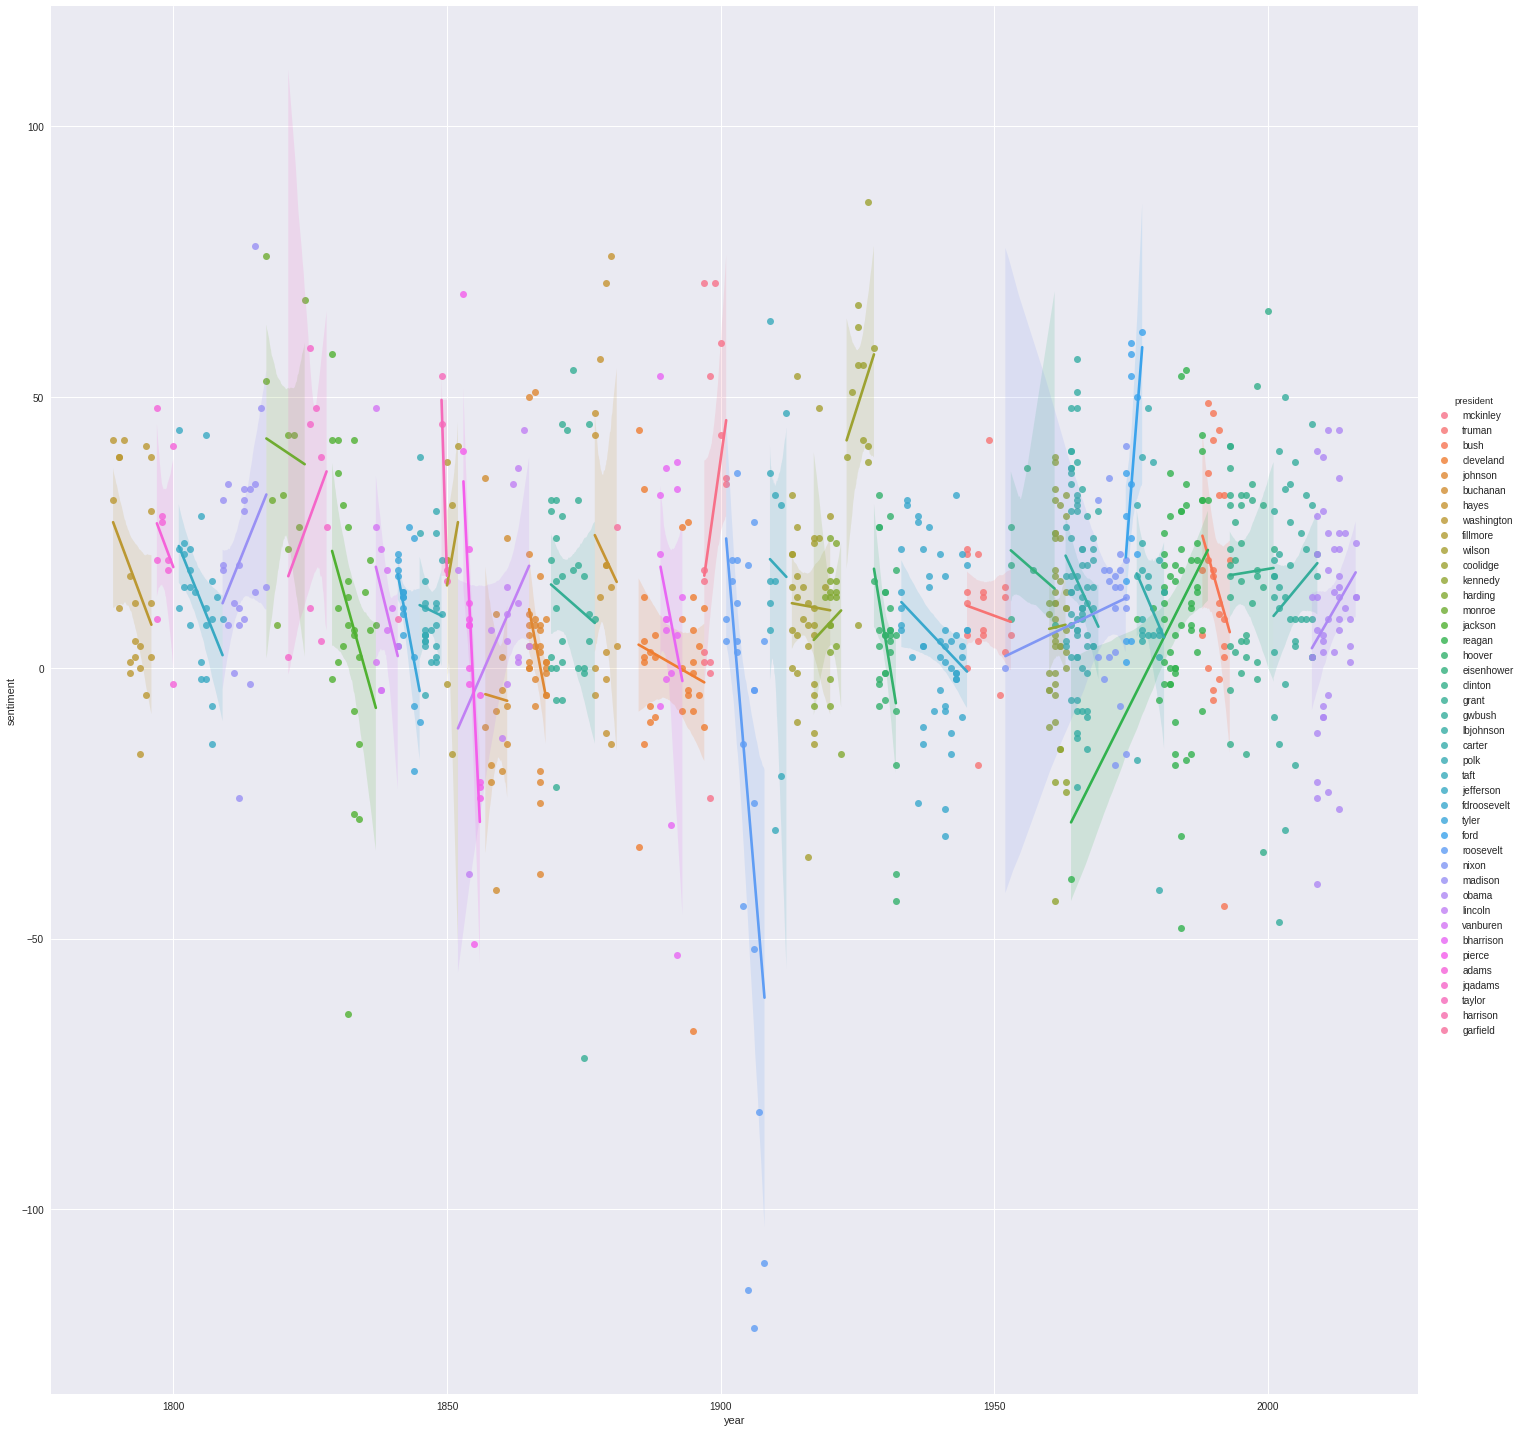

In [38]:
g = sns.lmplot(x="year", y="sentiment", hue="president", truncate=True, size=20, data=DF)

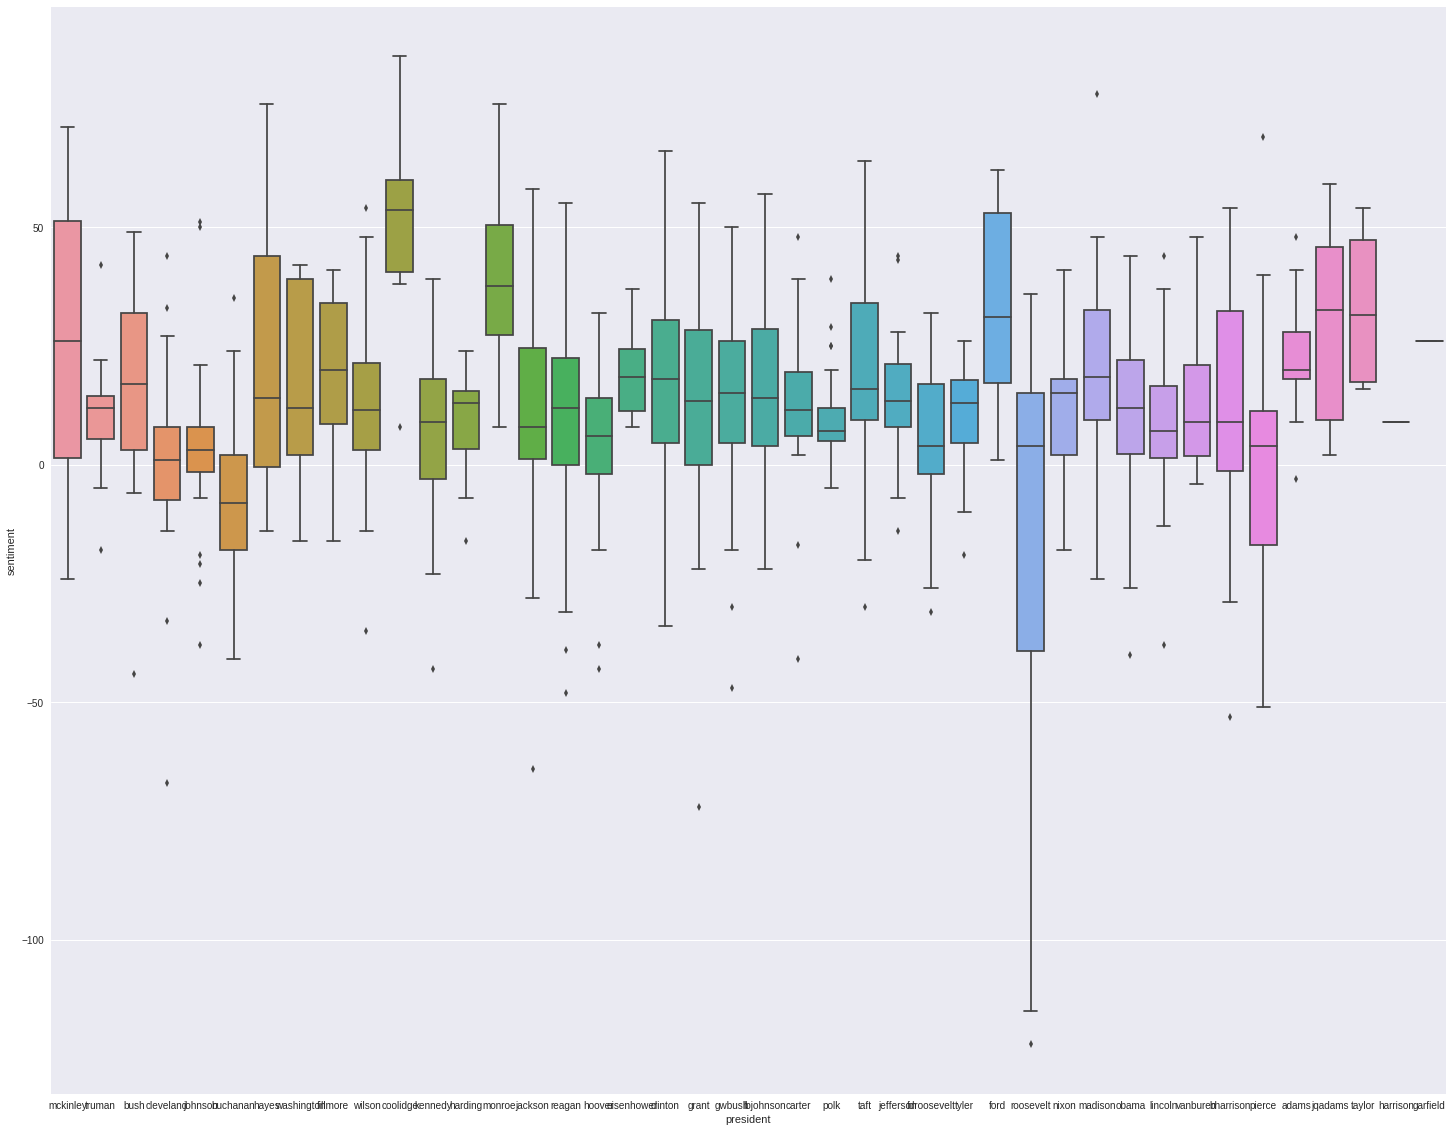

In [39]:
sns.set(rc={'figure.figsize':(25,20)})
g = sns.boxplot(x="president", y="sentiment", data=DF)

C'est un trè joli graphe mais quelque peu incompréhensible car surchargé d'information.  
Quoi qu'on peut deviner l'entrée en guerre des Etats-Unis en 1917 sans trop de problèmes.     
On va couper le jeu de donnée en 2 à partir de la seconde guerre mondiale pour essayer d'y voire plus clair.<br>

In [40]:
liste = ['kennedy','gwbush','bush','obama','trump','truman','clinton','eisenhower','fdroosevelt','nixon','ford','carter','reagan']

In [41]:
DF_aux = DF[DF["president"].isin(liste)] 

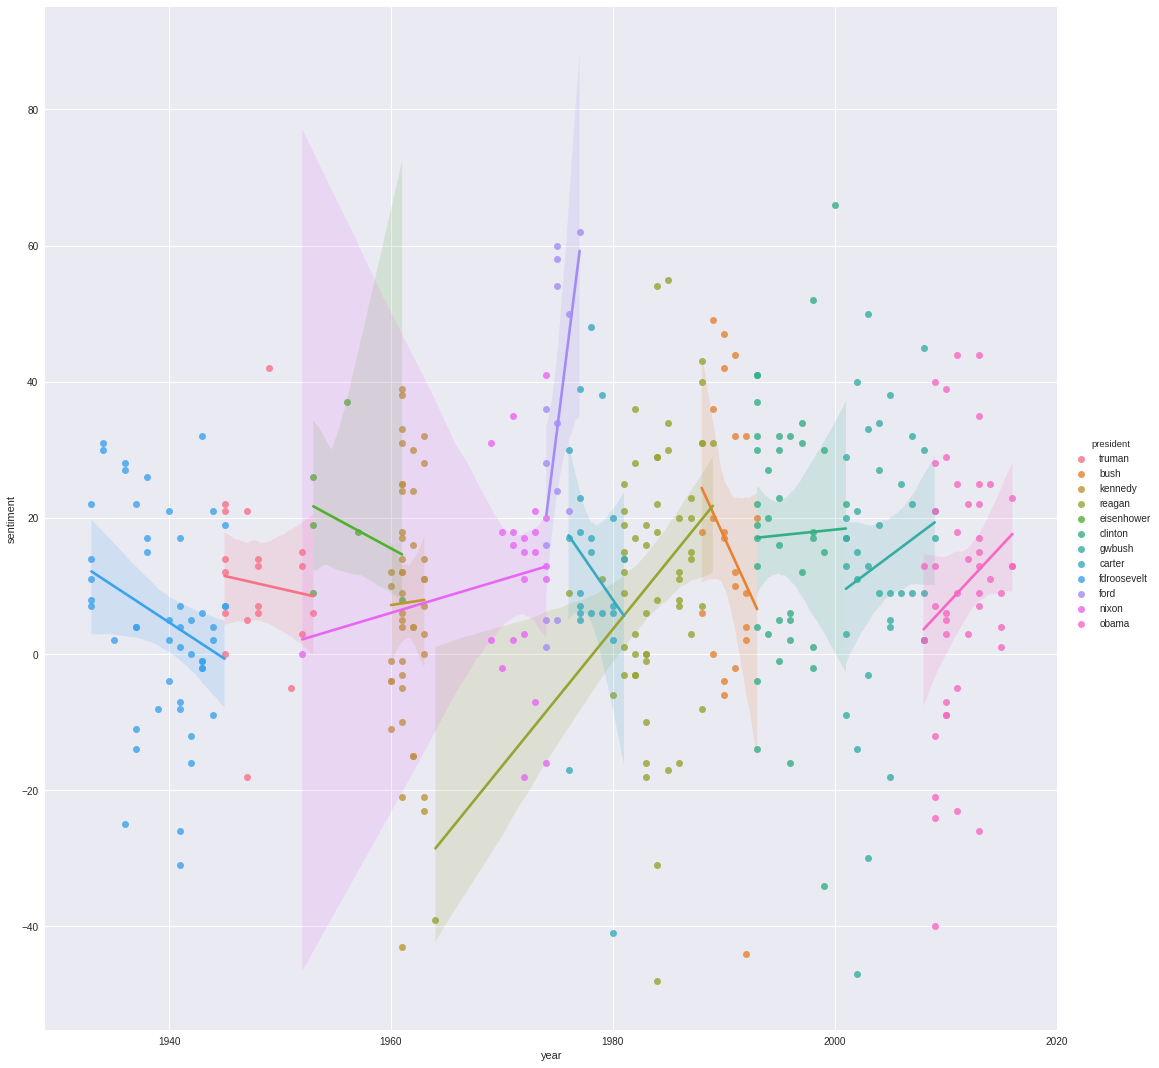

In [42]:
g = sns.lmplot(x="year", y="sentiment", hue="president", truncate=True, size=15, data=DF_aux)

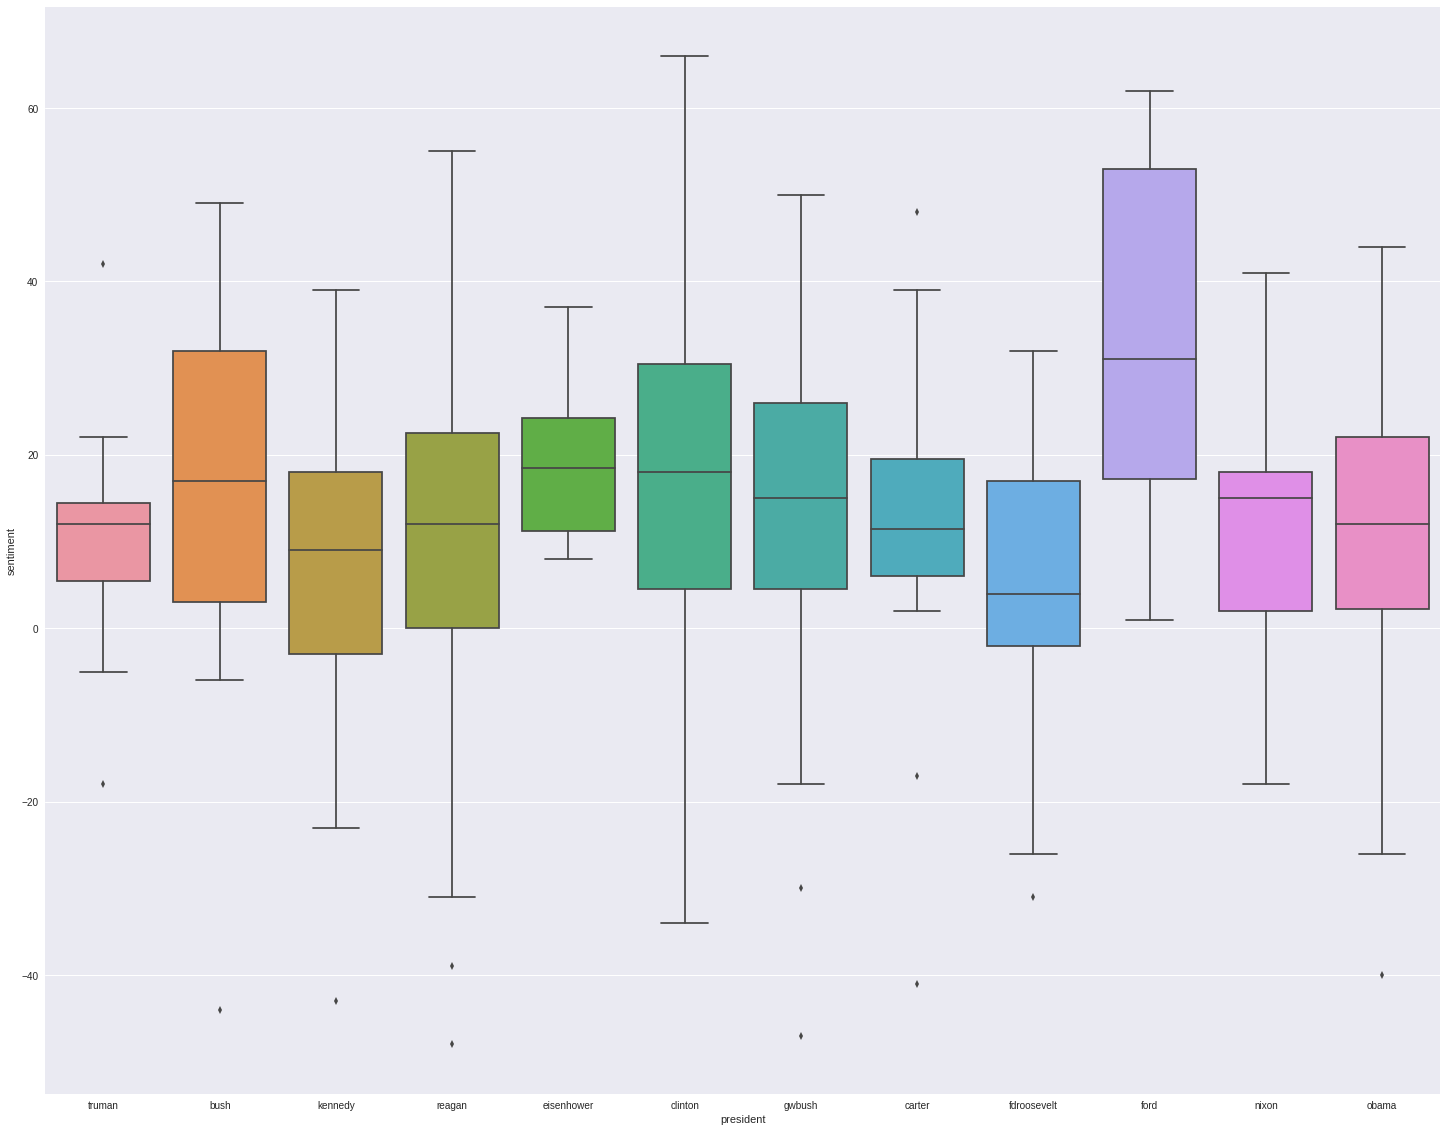

In [43]:
sns.set(rc={'figure.figsize':(25,20)})
g = sns.boxplot(x="president", y="sentiment", data=DF_aux)

### III.3) LSH par Min Hashing

ref : https://stackoverflow.com/questions/25114338/approximate-string-matching-using-lsh?rq=1

ref 2 : https://ekzhu.github.io/datasketch/lsh.html

In [42]:
m1 = MinHash(num_perm=120)
m1.update(df2["word_tokens"][0].encode('utf-8'))
m1.update(df2["word_tokens"][1].encode('utf-8'))

In [40]:
m2 = MinHash(num_perm=120)
m2.update(df2["word_tokens"][1].encode('utf-8'))

In [41]:
m2.hashvalues

array([2353693615, 3828745945, 2039717008,  449207360, 3974785510,
       2532485385, 3823767685, 3865962687, 4196798902,  286917968,
        382226269, 3971818286, 3024741081,  218017597, 2382525220,
       2592053256, 1515397013, 2383926003, 4165820461, 4187152759,
       2337751073, 1439885477,  720086247,  418935460, 1824608402,
       2082366070, 3297363481,   79802588, 2206069667, 1761364892,
       1244862983, 1889667573,  161223418, 1233778871,  742295982,
       3858340545, 1378445182, 3021691502, 1095556045,  745512217,
       1254840693, 1420476581, 1427961808,  116304002,  932936742,
       1465230416, 1021317540, 2025565052, 1863034230, 2606651610,
       1001164501, 1925835497, 1706194368, 3020219387,  619371795,
        399961240, 2792023780, 3698538738, 1784213627, 2823194452,
       3709091365,  730353699, 1789807968, 2186659797, 2671374620,
       3413204342, 4031474247, 2542215939, 1312347248,  273218743,
       1931712227, 1979665794,  414914861, 3784844484, 1356487

In [43]:
m1.hashvalues

array([1010270861, 1115826026, 2039717008,  449207360, 3715924217,
       1422300660, 3823767685,  474817434, 1984413554,  286917968,
        382226269, 1812123099, 2406386312,   83824809, 2382525220,
       2592053256, 1515397013, 1802395233, 4081322721, 4099432853,
       2337751073,  172621468,  720086247,  418935460,  430585148,
       2082366070, 2854764221,   79802588, 1224697568, 1761364892,
        481535428, 1131138848,  161223418, 1233778871,  742295982,
       3112470513,  633620576, 3021691502, 1095556045,  745512217,
        416305790, 1420476581, 1427961808,  116304002,  608828488,
       1465230416, 1021317540,   72953241, 1863034230,  732580555,
        329112041, 1925835497, 1706194368,  239453370,  619371795,
        399961240, 2792023780, 3479854730, 1784213627,  445849675,
       2041518444,  730353699, 1789807968, 1171999915, 2671374620,
       2279610693, 2270126582, 1974400674,  715090789,  273218743,
       1931712227, 1979665794,  414914861, 1139596787, 1081211

In [44]:
dic_min_hash = {}


for i in range(962):
    dic_min_hash["m"+ str(i)] = MinHash(num_perm=20)
    dic_min_hash["m"+ str(i)].update(df2["word_tokens"][i].encode('utf-8'))


for i in range(962):
    lsh = MinHashLSH(threshold = 0.1, num_perm = 20)
    for j in range(962):
        if j != i :
            lsh.insert("m"+str(j),dic_min_hash["m"+ str(j)])
    result = lsh.query(dic_min_hash["m"+ str(i)])
    if result != []:
        print("Approximate neighbours with Jaccard similarity > 0.50", result)

#### références additionelles utilisées pour faire ce notebook:

- pour se raffraichir la mémoire sur les présidents des USA : https://fr.wikipedia.org/wiki/Liste_des_pr%C3%A9sidents_des_%C3%89tats-Unis
- pour lire les textes du corpus : https://en.wikisource.org/wiki/Portal:State_of_the_Union_Speeches_by_United_States_Presidents 
- pour télécharger le jeu de donnée : http://www.thegrammarlab.com/?nor-portfolio=corpus-of-presidential-speeches-cops-and-a-clintontrump-corpus